In [1]:
# remove futurewarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import jax
import jax.numpy as jnp
from jax import jit
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from qdax_es.utils.count_plots import plot_archive_value
from qdax_es.core.containers.count_repertoire import CountMapElitesRepertoire

I0000 00:00:1719415901.614674  250960 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [3]:
from qdax_es.utils.gaussian_process import GPState, train_gp, gp_predict, gp_batch_predict

In [4]:
from jax.config import config
# jax.config.update("jax_enable_x64", True)

# config.update("jax_debug_nans", True)

In [5]:
num_centroids = 1000

# Bounds
minval, maxval = -1, 1

# Generate random centroids
random_key = jax.random.PRNGKey(0)
centroids = jax.random.uniform(random_key, (num_centroids, 2), minval=minval, maxval=maxval)

In [6]:
@jit
def f(x):
    return jnp.sin(x[0] + x[1]) * 50 - 200

count = jax.random.choice(random_key, jnp.arange(2), shape=(num_centroids,))
# count = jnp.ones(num_centroids)
# Put fitness if count > 0
mask = count > 0
fitnesses = jnp.where(mask, f(centroids.T), -jnp.inf)
descriptors = centroids
mask.sum()

Array(487, dtype=int32)

In [7]:
%matplotlib inline

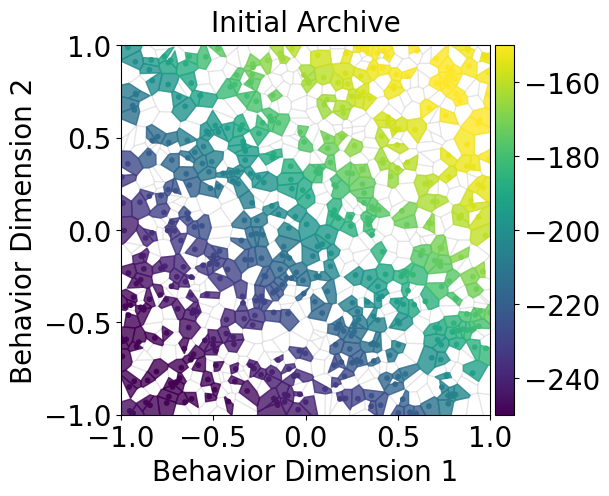

In [8]:
repertoire = CountMapElitesRepertoire(
    genotypes=None, 
    fitnesses=fitnesses,
    descriptors=descriptors,
    centroids=centroids,
    count=count,
)
plot_archive_value(
    repertoire=repertoire,
    y= fitnesses,
    title="Initial Archive",
    minval=minval,
    maxval=maxval,
)

%matplotlib inline

plt.show()

In [9]:
gp_state = GPState.init(
    x=centroids,
    y=fitnesses,
    weighted=False,
    count=count,
    empty_weight=1e3,
)

Valid params: 112
1000 RBFParams(sigma=Array(0.63670826, dtype=float32), lengthscale=Array(0.4084158, dtype=float32), obs_noise_sigma=Array(0.35222793, dtype=float32))
Mean: -1615.7979736328125 | 1083.9400634765625
Var: -10.813089370727539 | -2.214287281036377


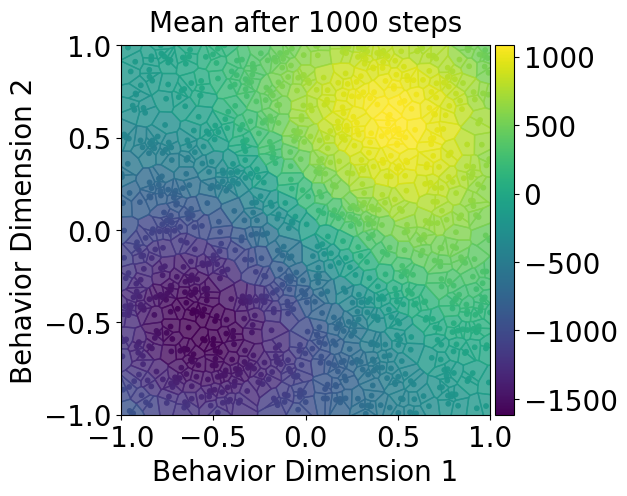

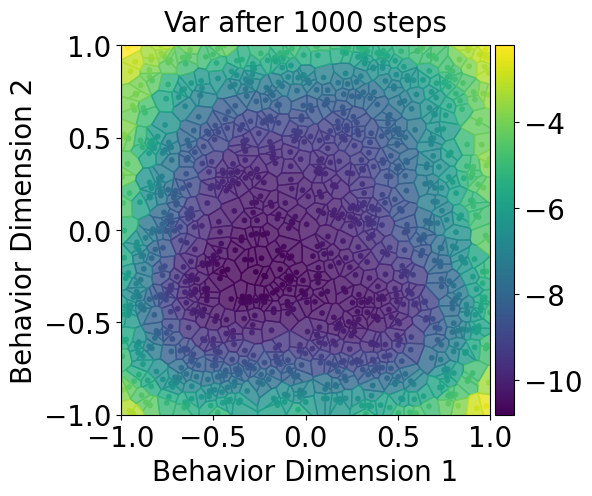

In [10]:
# Run the training loop with scan
steps = [1, 10, 100, 1000]
steps = [1000]

for num_steps in steps:
    with jax.disable_jit():
        fit_gp_state = train_gp(gp_state, num_steps=num_steps)
    print(num_steps, fit_gp_state.kernel_params)
    mean, var = gp_batch_predict(fit_gp_state, centroids)
    print(f"Mean: {mean.min()} | {mean.max()}")
    print(f"Var: {var.min()} | {var.max()}")
    plot_archive_value(
        repertoire=repertoire,
        y=mean,
        title=f"Mean after {num_steps} steps",
        minval=minval,
        maxval=maxval,
    )
    plot_archive_value(
        repertoire=repertoire,
        y=var,
        title=f"Var after {num_steps} steps",
        minval=minval,
        maxval=maxval,
    )
    plt.show()

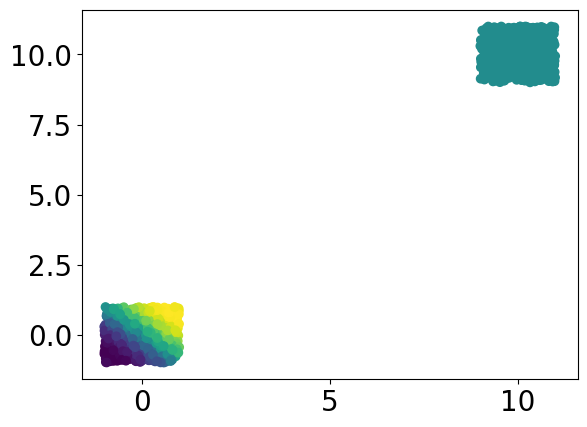

In [11]:
plt.scatter(fit_gp_state.x[:, 0], fit_gp_state.x[:, 1], c=fit_gp_state.y)

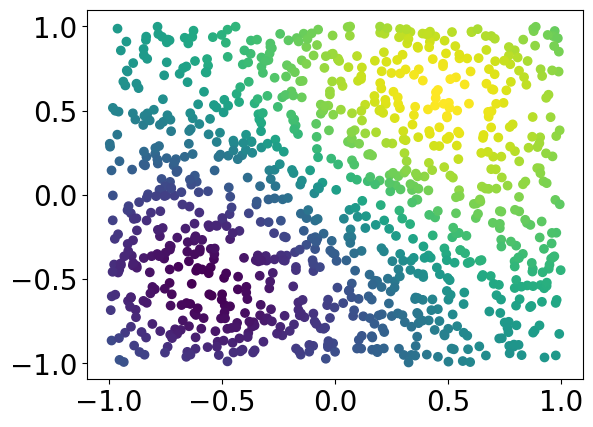

In [12]:
mean, var = gp_batch_predict(fit_gp_state, centroids)
plt.scatter(centroids[:, 0], centroids[:, 1], c=mean)

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'True fitness'}, xlabel='Behavior Dimension 1', ylabel='Behavior Dimension 2'>)

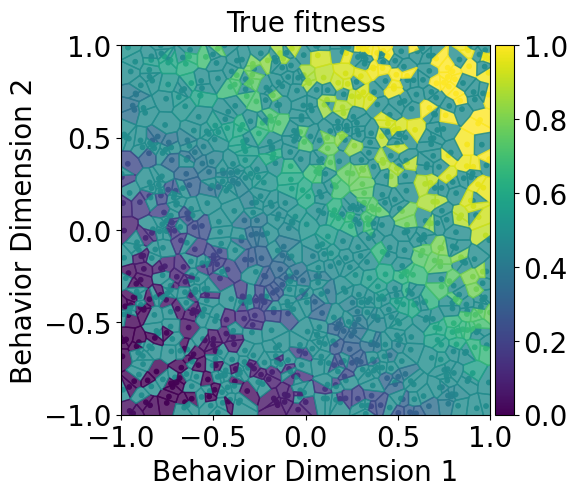

In [13]:
plot_archive_value(
    repertoire=repertoire,
    y=gp_state.y,
    title="True fitness",
    minval=minval,
    maxval=maxval,
)

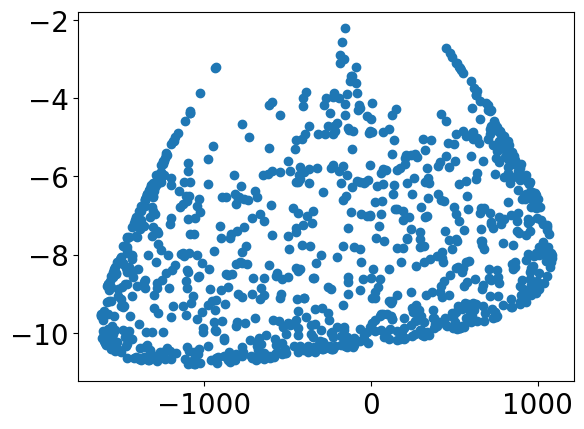

In [14]:
plt.scatter(mean, var)

In [15]:
import importlib
# pareto_mod = importlib.import_module("qdax_es.utils.pareto_selection")
# pareto_mod = importlib.reload(pareto_mod)

# pareto_front = pareto_mod.pareto_front

In [16]:
def pareto_filter(f1, f2):
    def is_dominated(x):
        """Check if a point is dominated."""
        return jnp.any((f1 > x[0]) & (f2 > x[1]))

    # zip f1 and f2
    f = jnp.vstack([f1, f2]).T
    dominated = jax.vmap(is_dominated)(f)
    return ~ dominated

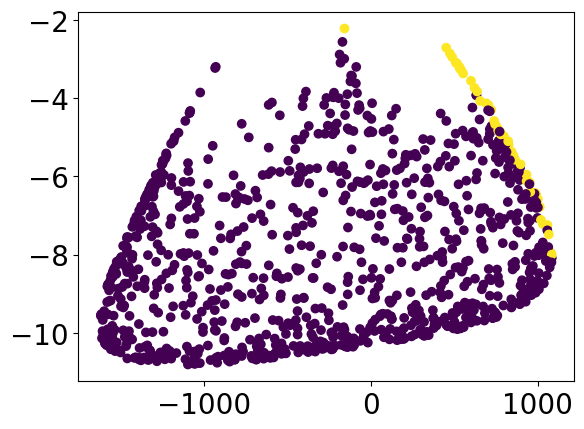

In [17]:
f = pareto_filter(mean, var)
plt.scatter(mean, var, c=f)

In [18]:
num_points = 60

indices = jnp.arange(num_centroids)
# proba
p = f / f.sum()
# select
selected = jax.random.choice(
    random_key, 
    indices, 
    shape=(num_points,), 
    p=p, 
    replace=False
    )
selected

Array([792, 719, 764, 897, 398, 835, 650, 129, 692, 445, 242, 918, 508,
       847, 964, 602, 642, 757, 883, 888, 926, 460,  84, 488, 687, 658,
       465, 184, 140, 903, 247, 436, 484, 374, 420, 360, 493, 877, 303,
       905, 896, 534,  50, 671, 309, 340, 521, 487, 159,   0,   1,   2,
         3,   4,   5,   6,   7,   8,   9,  10], dtype=int32)

In [19]:
for i in selected:
    print(i in indices[f])

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
